<a href="https://colab.research.google.com/github/mind-matrix/research-8th-sem-project/blob/main/ANN_Relation_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 11 22:27:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install tensorflow
!pip install tokenizers
!pip install transformers
!pip install numba

In [3]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import textwrap
from google.colab import files
import io
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
from tqdm import tqdm
from math import log2
import os

In [4]:
if os.path.exists("./dataset-annotated.csv"):
  df = pd.read_csv("./dataset-annotated.csv")
else:
  uploads = files.upload()
  df = pd.read_csv(io.BytesIO(list(uploads.values())[0]))

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [6]:
N = 200 # max input sequence length
T = 98 # num labels

In [7]:
flatten = lambda t: [item for sublist in t for item in sublist]

with tqdm(total=len(df.index)) as pbar:
  def encode_input(row):
    pbar.update(1)
    context = row['context'].replace(row['h'], "").replace(row['t'], "")
    encoding = tokenizer.encode(context)
    padded_encoding = [0]*N
    l = len(encoding)
    padded_encoding[0:min(N,l)] = encoding[0:min(N,l)]
    return padded_encoding

df['input'] = df.apply(encode_input, axis=1)
df['label'] = df['target'].apply(lambda x: [ 1 if i == x else 0 for i in range(0, T) ])
df = df[['input', 'label']]
df.head()

  0%|          | 0/12323 [00:00<?, ?it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


,input,label
0,"[101, 23404, 2486, 2001, 2019, 4195, 2511, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 23404, 2486, 2001, 2019, 4195, 2511, 199...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[101, 23404, 2486, 2001, 2019, 4195, 2511, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[101, 23404, 2486, 2001, 2019, 2827, 2390, 419...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[101, 23404, 2486, 2001, 2019, 1050, 2390, 419...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
X = df['input'].to_list()
Y = df['label'].to_list()
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2)

In [9]:
def create_model(N, T=T):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(N)),
      *[ tf.keras.layers.Dense(max(N/(2**i), T)) for i in range(0, int(log2(N/T))) ],
      tf.keras.layers.Dense(T, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  
  return model

In [10]:
from tensorflow.keras import backend as K
from numba import cuda
K.clear_session()
cuda.select_device(0)
cuda.close()

In [11]:
model = create_model(N)

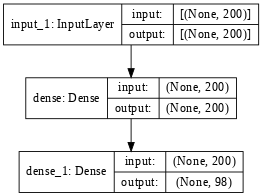

In [12]:
tf.keras.utils.plot_model(model, dpi=64, show_shapes=True, expand_nested=True)

In [13]:
tf.config.experimental_run_functions_eagerly(True)
model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, batch_size=16)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
617/617 [==============================] - 10s 16ms/step - loss: 9020.7980 - accuracy: 0.1896 - val_loss: 4310.4751 - val_accuracy: 0.2154
Epoch 2/10
617/617 [==============================] - 7s 12ms/step - loss: 3534.3346 - accuracy: 0.1987 - val_loss: 3298.5713 - val_accuracy: 0.2130
Epoch 3/10
617/617 [==============================] - 8s 12ms/step - loss: 2489.2605 - accuracy: 0.2133 - val_loss: 2960.1819 - val_accuracy: 0.2268
Epoch 4/10
617/617 [==============================] - 7s 12ms/step - loss: 2069.6901 - accuracy: 0.2049 - val_loss: 2553.5432 - val_accuracy: 0.2389
Epoch 5/10
617/617 [==============================] - 7s 12ms/step - loss: 1722.7660 - accuracy: 0.2208 - val_loss: 2270.2656 - val_accuracy: 0.2402
Epoch 6/10
617/617 [==============================] - 7s 12ms/step - loss: 1448.7235 - accuracy: 0.2223 - val_loss: 2074.7278 - val_accuracy: 0.2357
Epoch 7/10
617/617 [==============================] - 8s 12ms/step - loss: 1333.9396 - accuracy: 0.2243 -